In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Grossery Zincir Mağazalarının Web Sitesi 

* **Burada ele alınan şirketin hedeflerinden birisi, daha fazla kullanıcıya mobil uygulamayı indirtmek ve müşteri sadakat programına kaydolmaya yönlendirmek.**

* **Şirket, uygulama mağazasının bir butonunda bağlantı değişikliği yapıyor ve uygulama indirme sayfası için tıklama oranlarının artıp artmayacağını soruyor ?**

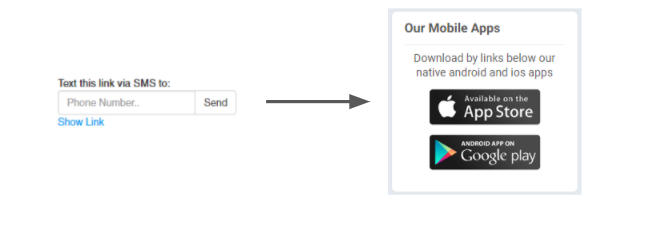

In [ ]:
# Analiz için gerekli kütüphanelerin ortama yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import shapiro
from scipy import stats

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
# Grossery websitesi datasının yüklenmesi
data = pd.read_csv("/kaggle/input/grocery-website-data-for-ab-test/grocerywebsiteabtestdata.csv")
df = data.copy()
df.head()

## Veri setini tanımlayalım
* Bu veride hedeflediğimiz örneklem hesabı olmayan ve web sitemizi ziyaret eden müşteriler.
* Testin süresi 1 haftadır.
* Treatment ve Control grubu olmak üzere iki grubumuz vardır. Treatment grubu yeni sistem, Control grubu ise eski sistem üzerinden değerlendirmeler alınmıştır.
* Grupların büyüklüğü toplam veride Treatment 1/3, Control 2/3.


## Değişkenler
* IP Address: Müşterinin IP Adresi
* LoggedInFlag: Kullanıcının web sitemizde profili olup olmadığını gösterir
* ServerID: Treatment ve Control grubuna ait olma durumu, 1: Treatment , 2-3: Control
* VisitPageFlag: Kullanıcının download bağlantısına tıklama durumu

# Veri Hazırlama

In [ ]:
# RecordID gereksiz bir sütun oldugu icin kaldıralım
# Veri setini IP adresi ve kullanıcının bağlantıya tıklamasına göre tekrar düzenleyelim
# Bu düzenlemeyi yaparken VisitPageFlag sütununu toplamları şeklinde değiştiriyoruz
df = df.groupby(["IP Address", "LoggedInFlag", "ServerID"])["VisitPageFlag"].sum()

In [ ]:
df.head()

In [ ]:
df = df.reset_index(name="VisitPageFlagSum")

In [ ]:
# birden fazla tıklanmaya sahip IP adresi olup olmadığını kontrol edelim ve bunu veriye degisken olarak ekleyelim
df["VisitFlag"] = df["VisitPageFlagSum"].apply(lambda x: 1 if x != 0 else 0)
df.head()

In [ ]:
# Treatment ve Control gruplarını gösteren bir sütun ekleyelim
df["group"] = df["ServerID"].map({1: "Treatment", 2:"Control", 3:"Control"})
df.head()

In [ ]:
# bizim inceleyeciğimiz grup hesabı olmayanlar olacağı için filtreleme işlemi yapalım
df = df[df["LoggedInFlag"] == 0]
df.head()

In [ ]:
# Treatment ve Control gruplarını oluşturalım
treatment = df[df["group"] == "Treatment"]
control = df[df["group"] == "Control"]

In [ ]:
treatment.head()

In [ ]:
control.head()

In [ ]:
# iki grup ortalamasına bakalım
print(treatment["VisitFlag"].mean())
print(control["VisitFlag"].mean())

# Bağımsız İki Örneklem T Testi

# Varsayımlar

* Normallik Varsayımı
* Varyans Homojenliği Varsayımı

## Varsayım Kontrolü

### Normallik varsayımı
* H0: Normal dağılım varsayımı sağlanmaktadır
* H1: Normal dağılım varsayımı sağlanmamaktadır

In [ ]:
test_istatistigi, p_value = shapiro(treatment["VisitFlag"])
print('Test İstatistiği = %.4f, p-değeri = %.4f' % (test_istatistigi, p_value))

In [ ]:
test_istatistigi, p_value = shapiro(control["VisitFlag"])
print('Test İstatistiği = %.4f, p-değeri = %.4f' % (test_istatistigi, p_value))

### Varyans homojenligi varsayımı

* H0: varyanslar homojendir
* H1: varyanslar homojen degildir

In [ ]:
test_istatistigi, p_value = stats.levene(treatment["VisitFlag"],
            control["VisitFlag"])
print('Test İstatistiği = %.4f, p-değeri = %.4f' % (test_istatistigi, p_value))

* Her iki varsayımımızda da p-value değerimiz 0.05'ten küçük olduğu için H0 hipotezimizi reddediyoruz ve varsayımlar sağlanmadığından dolayı nonparametrik olan mannwhitneyu testini gerçekleştiriyoruz

# Hipotez
* H0: M1 = M2 (İki grup ortalaması arasında istatistiksel olarak anlamlı bir farklılık yoktur)
* H1: M1 != M2 (İki grup ortalaması arasında istatistiksel olarak anlamlı bir farklılık vardır)

In [ ]:
# Varsayımlar saglanmadı nonparametrik test yapacagız
test_istatistigi, p_value = stats.mannwhitneyu(treatment["VisitFlag"],
                                              control["VisitFlag"])
print('Test İstatistiği = %.4f, p-değeri = %.4f' % (test_istatistigi, p_value))

* p-value değerimiz 0.05'ten küçük olduğundan dolayı ilgili H0 hipotezini reddediyoruz.

In [ ]:
# gruplar arasında bir fark olacağını görüyoruz h0 reddediyoruz ve istatistiksel olarak bi anlamlılık vardır diyoruz.
# treatment ve control gruplarının ziyaretlerini saydıralım ve bağlantıya tıklayıp tıklamadıklarına bakalım
group_count = df.groupby(['group', 'VisitFlag'])['group'].count().reset_index(name='Count')

In [ ]:
group_count

In [ ]:
# yüzde farkları görelim
df.groupby('group').VisitFlag.mean()

In [ ]:
groupped = pd.crosstab(group_count['group'], group_count['VisitFlag'], values=group_count['Count'], aggfunc=np.sum, margins=True)
groupped

In [ ]:

100*groupped.div(groupped['All'], axis=0)

# Sonuç
### Control grubunda bağlantıya tıklayanların oranı %18.5 iken Treatment grubunda bağlantıya tıklayanların oranı %23.2 arada %4.7'lik bir fark var.
### Bu da demek oluyor ki şirketimizin AppStore ve PlayStore butonu bağlantısını değiştirmesi durumunda %4 bir artışla daha fazla kullanıcıyı uygulamayı indirmeye ve tıklamaya yönlendirecektir. 